<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day1/1_data_preperation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation for a classification model

In our first exercise, we will download the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60,0000 small images (32 x 32 pixel) and 10 different classes (automobile, airplane, ...).

Here, we will learn how to visualize the data and prepare it for training a classifier model.
In addition, we will see how to connect to run the exercises in google colab. 

## Import python libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from tqdm import tqdm

In [2]:
# install a helper function to download and extract the cifar data
!pip install cifar2png

  Using cached cifar2png-0.0.4.tar.gz (5.8 kB)
  Using cached pathlib-1.0.1.tar.gz (49 kB)
  Using cached requests-2.24.0-py2.py3-none-any.whl (61 kB)
  Using cached tqdm-4.48.2-py2.py3-none-any.whl (68 kB)
  Using cached chardet-3.0.4-py2.py3-none-any.whl (133 kB)
  Using cached urllib3-1.25.10-py2.py3-none-any.whl (127 kB)
  Using cached idna-2.10-py2.py3-none-any.whl (58 kB)
  Created wheel for cifar2png: filename=cifar2png-0.0.4-py3-none-any.whl size=5932 sha256=e87c0d97fb8fddad5f4cf813f8d2a15e57e7366ffa1b8d80569525d466506398
  Stored in directory: /home/pape/.cache/pip/wheels/74/98/2e/cc61a90cf96d657a7e7384904658ae7b561514c117af9438cc
  Created wheel for pathlib: filename=pathlib-1.0.1-py3-none-any.whl size=14348 sha256=f760e5383e3ef5fcaae46c2a9744070e3905df45f7f9242274b0d5fdc1e86c41
  Stored in directory: /home/pape/.cache/pip/wheels/59/02/2f/ff4a3e16a518feb111ae1405908094483ef56fec0dfa39e571
Successfully built cifar2png pathlib


## Download and read the data

We download and load the images and corresponding labels to inspect them (and later use it to train a classifier).

The data is organised as follows:

```
train/
  airplane/
    001.png
    002.png
    ...
  automobile/
    001.png
    002.png
    ...
```

and similarly for the test data.

In [19]:
cifar_dir = './cifar10'
!cifar2png cifar10 cifar10

output dir `cifar10` already exists. Please specify a different output path


In [20]:
# first, list the categories available in the data
data_dir = os.path.join(cifar_dir, "train")
categories = os.listdir(data_dir)
categories.sort()
print(categories)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [21]:
# next load the images and labels as lists
images = []
labels = []
for label_id, category in tqdm(enumerate(categories), total=len(categories)):
    category_dir = os.path.join(data_dir, category)
    image_names = os.listdir(category_dir)
    for im_name in image_names:
        im_file = os.path.join(category_dir, im_name)
        images.append(imread(im_file))
        labels.append(label_id)
        
# from lists to arrays.
# for th images, we stack along a new first axis
images = np.concatenate([im[None] for im in images], axis=0)
labels = np.array(labels)

print("Number of images:", len(images))
print("Number of labels:", len(labels))

100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


Number of images: 50000
Number of labels: 50000


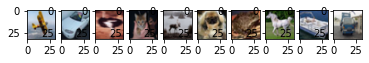

In [22]:
# plot an image for each category
fig, ax = plt.subplots(1, 10)
label_list = labels.tolist()
for label_id, category in enumerate(categories):
    ax[label_id].imshow(images[label_list.index(label_id)])
    # ax[label_id].set_title(category)
plt.show()

## Convolutional Filters

TODO conv filters are important, will later need that concept a lot.
To get started, let's just a apply a few filters to one of our images.
You can use the library [skimage.filters](https://scikit-image.org/docs/dev/api/skimage.filters.html).

In [24]:
import skimage.filters as filters
image = images[0]
filtered_gaussian = filters.gaussian(image, sigma=1., multichannel=True)
filtered_laplacian = filters.laplace(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


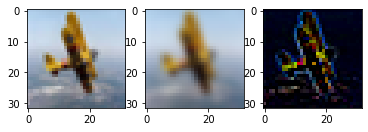

In [25]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(image)
ax[1].imshow(filtered_gaussian)
ax[2].imshow(filtered_laplacian)

## Preparation for pytorch

In order to use the CIFAR data to train a classifier with pytorch, we need to bring the data into a format
that can be ingested by pytorch. To this end, we will create:
- a dataset: this datastructure stores the images and labels used during training
- transforms: these are functions that are applied to the images and/or labels on the fly when the image is loaded

In [26]:
import torch
# datasets have to be sub-classes from torch.util.data.Dataset
from torch.utils.data import Dataset

class DatasetWithTransform(Dataset):
    """ Our minimal dataset class. It holds data and target
    as well as optional transforms that are applied to data and target
    on the fly when data is requested via the [] operator.
    """
    def __init__(self, data, target, transform=None):
        assert isinstance(data, np.ndarray)
        assert isinstance(target, np.ndarray)
        self.data = data
        self.target = target
        if transform is not None:
            assert callable(transform)
        self.transform = transform

    # exposes the [] operator of our class
    def __getitem__(self, index):
        data, target = self.data[index], self.target[index]
        if self.transform is not None:
            data, target = self.transform(data, target)
        return data, target

    def __len__(self):
        return self.data.shape[0]

In [27]:
# what transofrmations do we need to feed the data here to pytorch?

# first, let's check the shape of our images:
print(image.shape)

(32, 32, 3)


In [28]:
# as we see, the images are stored as WHC, i.e. the first two axes are the image axes and the last axis
# corresponds to the color channel.
# pytorch however expects the color channel as first axis, i.e. CWH.
# so our first transform needs to switch the chanels
# note that all transformations work on the image and target, so here we just leave the target alone
def to_channel_first(image, target):
    """ Transform images with color channel last (WHC) to channel first (CWH)
    """
    # put channel first
    image = image.transpose((2, 0, 1))
    return image, target

In [29]:
# next, let's see what datatype and value range our images have
print(image.dtype)
print(image.min(), image.max())

uint8
0 245


In [30]:
# as we can see, the images are stored in 8 bit integers with a value range [0, 255]
# instead, torch expects images as 32 bit floats and normalized to a 'reasonable' data range.
# here, we normalize the image such that all channels are in range 0 to 1
def normalize(image, target, channel_wise=True):
    eps = 1.e-6
    image = image.astype('float32')
    chan_min = image.min(axis=(1, 2), keepdims=True)
    image -= chan_min
    chan_max = image.max(axis=(1, 2), keepdims=True)
    image /= (chan_max + eps)
    return image, target


# finally, we need to transform our input from a numpy array to a torch tensor
def to_tensor(image, target):
    return torch.from_numpy(image), torch.tensor([target], dtype=torch.int64)
    

# we also need a way to compose multiple transformations
def compose(image, target, transforms):
    for trafo in transforms:
        image, target = trafo(image, target)
    return image, target

In [31]:
# create the dataset with transformations
from functools import partial  # to bind function arguments

trafos = [to_channel_first, normalize, to_tensor]
trafo = partial(compose, transforms=trafos)

dataset = DatasetWithTransform(images, labels, transform=trafo)

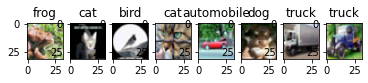

In [32]:
# function to show an image target pair returned from the dataset
def show_image(ax, image, target):
    # need to go back to numpy array and WHC axis order
    image = image.numpy().transpose((1, 2, 0))
    # find the label name
    label = categories[target.item()]
    ax.imshow(image)
    ax.set_title(label)

    
# sample a few images from the dataset to check their label
n_images = len(dataset)
n_samples = 8

fig, ax = plt.subplots(1, n_samples)
for sample in range(n_samples):
    # datasets are random access, so we can request
    # an image / target at an arbitrary index
    sample_id = np.random.randint(0, n_images)
    image, target = dataset[sample_id]
    
    # make sure that the image is in range 0, 1
    assert np.isclose(image.min(), 0.)
    assert np.isclose(image.max(), 1.)
    
    # add the image to our plots
    show_image(ax[sample], image, target)

## Tasks and Questions

- Aply more advanced transforms: for example you could blur the images or rotate them on the fly.

## Torchvision

Note: there is torch library for computer vision tasks: [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). It has many datasets, transformations etc. already. For example a [prefab cifar dataset](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar).

We do not use torchvision here for two reasons:
- to show how this works under the hood, because if your dataset of choice is not in torchvision you need to write a dataset
- torchvision uses [PIL](https://pillow.readthedocs.io/en/stable/) to represent images, which is rather outdated

Still, torchvision contains helpful functionality and many datasets, so it's a very useful library.